<a href="https://colab.research.google.com/github/mitkrieg/citibike-timeseries/blob/main/fbprophet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from fbprophet import Prophet
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Flatiron/Capstone/data

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/Flatiron/Capstone/data


In [8]:
%cd ..
% ls

/gdrive/MyDrive/Flatiron/Capstone
cleaning.py  fbprophet_model.ipynb  __pycache__/   trips.pickle
data/        historical.pickle      starts.pickle
ends.pickle  live.pickle            station.py


In [9]:
df = pickle.load(open('/gdrive/MyDrive/Flatiron/Capstone/data/train_ts.pickle','rb'))
df_test = pickle.load(open('/gdrive/MyDrive/Flatiron/Capstone/data/test_ts.pickle','rb'))

In [10]:
df

,ds,y
0,2018-06-17 00:00:00,5.0
1,2018-06-17 01:00:00,3.5
2,2018-06-17 02:00:00,3.0
3,2018-06-17 03:00:00,2.0
4,2018-06-17 04:00:00,2.0
...,...,...
331,2018-06-30 19:00:00,14.0
332,2018-06-30 20:00:00,3.0
333,2018-06-30 21:00:00,9.5
334,2018-06-30 22:00:00,10.0


In [11]:
df_test

,ds,y
0,2018-06-18 00:00:00,2.5
1,2018-06-18 01:00:00,1.0
2,2018-06-18 02:00:00,12.0
3,2018-06-18 03:00:00,11.5
4,2018-06-18 04:00:00,11.0
...,...,...
643,2018-07-14 19:00:00,1.0
644,2018-07-14 20:00:00,3.0
645,2018-07-14 21:00:00,4.5
646,2018-07-14 22:00:00,2.5


In [12]:
m = Prophet(growth = 'flat',daily_seasonality=True, weekly_seasonality=True)
m.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [13]:
future = m.make_future_dataframe(periods = 14*24, freq='H')
future

,ds
0,2018-06-17 00:00:00
1,2018-06-17 01:00:00
2,2018-06-17 02:00:00
3,2018-06-17 03:00:00
4,2018-06-17 04:00:00
...,...
667,2018-07-14 19:00:00
668,2018-07-14 20:00:00
669,2018-07-14 21:00:00
670,2018-07-14 22:00:00


In [14]:
forcast = m.predict(future)
forcast[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-06-17 00:00:00,12.914824,6.282635,19.080438
1,2018-06-17 01:00:00,12.377725,6.031735,19.064861
2,2018-06-17 02:00:00,12.222265,5.588693,18.848596
3,2018-06-17 03:00:00,12.534084,5.952554,18.974158
4,2018-06-17 04:00:00,12.831202,6.134483,18.967048
...,...,...,...,...
667,2018-07-14 19:00:00,11.790824,5.304662,18.274824
668,2018-07-14 20:00:00,13.298568,6.976706,20.136365
669,2018-07-14 21:00:00,13.889246,7.368039,19.964237
670,2018-07-14 22:00:00,13.877810,7.326636,20.102768


In [15]:
train_ts = df.set_index('ds')
forcast_ts = forcast.set_index('ds')
test_ts = df_test.set_index('ds')

In [16]:
forcast_ts.yhat_upper.sort_values()

ds
2018-07-01 10:00:00     4.484081
2018-06-17 10:00:00     4.595951
2018-07-08 10:00:00     4.647731
2018-06-24 10:00:00     4.693292
2018-06-24 11:00:00     4.708190
                         ...    
2018-07-05 05:00:00    27.236603
2018-06-21 04:00:00    27.469722
2018-06-28 04:00:00    27.536634
2018-07-12 04:00:00    27.662592
2018-07-05 04:00:00    27.667043
Name: yhat_upper, Length: 672, dtype: float64

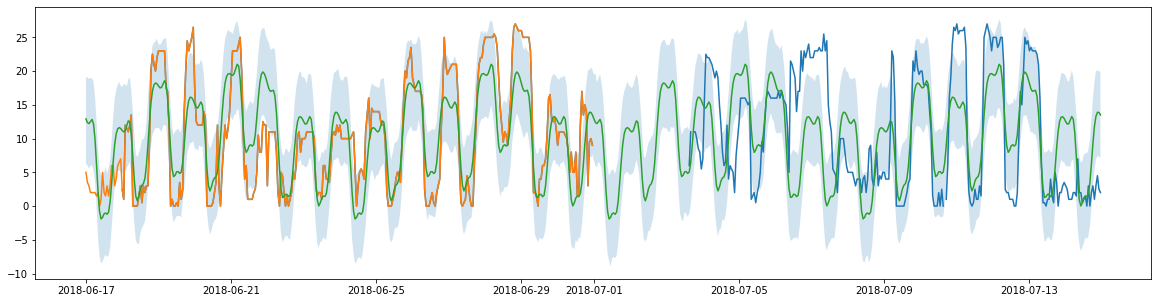

In [17]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)
ax.plot(test_ts,label='test')
ax.plot(train_ts,label='train')
ax.plot(forcast_ts.yhat,label='forcast')
ax.fill_between(forcast_ts.index,forcast_ts.yhat_lower,forcast_ts.yhat_upper,alpha=0.2)

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [19]:
train_rmse = mean_squared_error(y_true=train_ts,
                   y_pred=forcast_ts.yhat[:'2018-06-30'],
                   squared=False)

test_rmse = mean_squared_error(y_true=test_ts['2018-07-03 15:00:00':].interpolate(),
                               y_pred=forcast_ts.yhat['2018-07-03 15:00:00':],
                               squared=False)

train_mae = mean_absolute_error(y_true=train_ts,
                   y_pred=forcast_ts.yhat[:'2018-06-30'])

test_mae = mean_absolute_error(y_true=test_ts['2018-07-03 15:00:00':].interpolate(),
                               y_pred=forcast_ts.yhat['2018-07-03 15:00:00':])

print(f'Train RMSE: {train_rmse}')
print(f'Train MAE:  {train_mae}\n')

print(f'Test RMSE: {test_rmse}')
print(f'Test MAE:  {test_mae}')

Train RMSE: 5.0408323291500325
Train MAE:  4.122646416308141

Test RMSE: 7.7349786684867565
Test MAE:  6.226711176838252


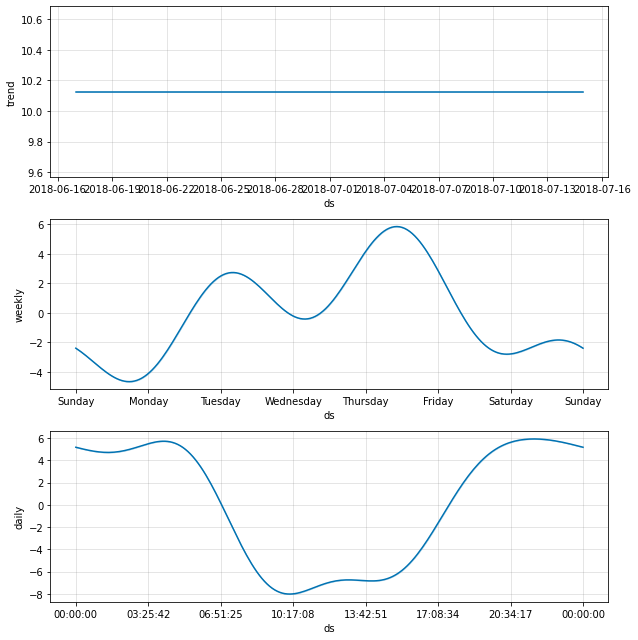

In [20]:
m.plot_components(forcast);

In [21]:
from fbprophet.diagnostics import performance_metrics, cross_validation
from station import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [22]:
year_2018 = pickle.load(open('historical.pickle','rb'))

In [21]:
search_station_id('Amsterdam')

,station_name,station_id
371,Amsterdam Ave & W 73 St,3167
374,Amsterdam Ave & W 82 St,3171
377,W 70 St & Amsterdam Ave,3175
441,W 87 St & Amsterdam Ave,3285
445,W 90 St & Amsterdam Ave,3289
505,Amsterdam Ave & W 66 St,3356
506,W 106 St & Amsterdam Ave,3357
638,W 110 St & Amsterdam Ave,3538
639,W 116 St & Amsterdam Ave,3539
641,Amsterdam Ave & W 125 St,3541


In [67]:
station_3172 = year_2018.loc[3172]

In [68]:
station_3172.head()

,station_name,avail_bikes,avail_docks,tot_docks,_lat,_long,in_service,status_key,percent_full,season
date_time,,,,,,,,,,
2018-01-01 00:26:00,W 74 St & Columbus Ave,26,1,27,40.778567,-73.97755,1,1,0.962963,winter
2018-01-01 00:59:00,W 74 St & Columbus Ave,26,1,27,40.778567,-73.97755,1,1,0.962963,winter
2018-01-01 01:32:00,W 74 St & Columbus Ave,26,1,27,40.778567,-73.97755,1,1,0.962963,winter
2018-01-01 02:04:00,W 74 St & Columbus Ave,26,1,27,40.778567,-73.97755,1,1,0.962963,winter
2018-01-01 02:38:00,W 74 St & Columbus Ave,26,1,27,40.778567,-73.97755,1,1,0.962963,winter


In [132]:
availbikes = station_3172.reset_index()[['date_time','avail_bikes']]
availbikes.rename(columns={'date_time':'ds','avail_bikes':'y'}, inplace=True)
availbikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11122 entries, 0 to 11121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      11122 non-null  datetime64[ns]
 1   y       10263 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 173.9 KB


In [133]:
#station_3172.loc['2018-08-09 03:00:00':'2018-09-11 17:00:00','avail_bikes'] = np.nan

In [134]:
year_model = Prophet(growth= 'flat',yearly_seasonality=False,weekly_seasonality=True,daily_seasonality=True)
year_model.fit(availbikes)

In [135]:
future = year_model.make_future_dataframe(periods = 24*119,freq='H')
forcast = year_model.predict(future)
forcast[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-01-01 00:26:00,11.444066,2.608714,20.612404
1,2018-01-01 00:59:00,11.480304,3.213756,20.477332
2,2018-01-01 01:32:00,11.551958,2.411747,20.827875
3,2018-01-01 02:04:00,11.694299,3.230158,20.402015
4,2018-01-01 02:38:00,11.949604,2.841426,20.516530
...,...,...,...,...
13973,2019-04-29 19:30:00,10.928350,1.434272,20.132097
13974,2019-04-29 20:30:00,12.382123,3.734700,21.149464
13975,2019-04-29 21:30:00,13.344974,4.161075,23.320421
13976,2019-04-29 22:30:00,13.958874,4.768597,23.337216


In [136]:
forcast_year_ts = forcast.set_index('ds')
true_year_ts = availbikes.set_index('ds')

(736862.0, 736889.0, -5.0, 45.0)

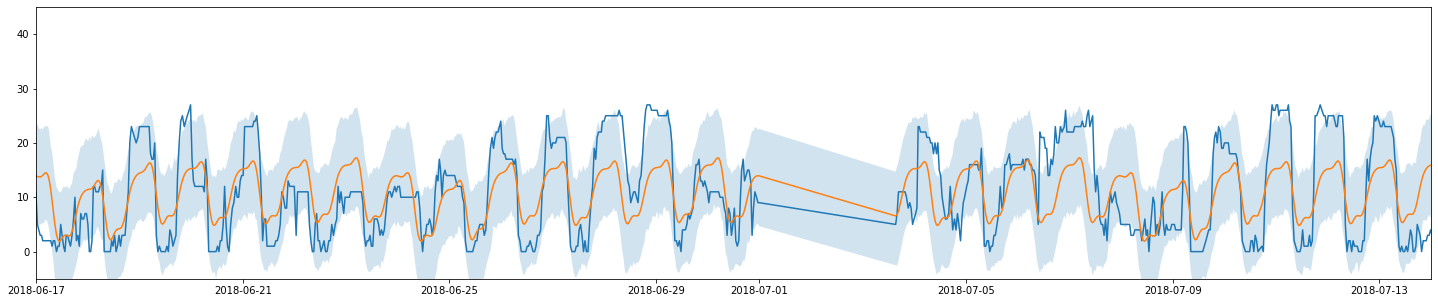

In [137]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(25)
#ax.plot(test_ts,label='test')
ax.plot(true_year_ts,label='train')
ax.plot(forcast_year_ts.yhat,label='forcast')
ax.fill_between(forcast_year_ts.index,forcast_year_ts.yhat_lower,forcast_year_ts.yhat_upper,alpha=0.2)
plt.axis([np.datetime64('2018-06-17'),np.datetime64('2018-07-14'),-5,45])

In [138]:
train_rmse = mean_squared_error(y_true=true_year_ts.y.interpolate(),
                   y_pred=forcast_year_ts.yhat[:'2018-12-31'],
                   squared=False)

# test_rmse = mean_squared_error(y_true=true_year_ts.interpolate(),
#                                y_pred=forcast_ts.yhat['2018-07-03 15:00:00':],
#                                squared=False)

train_mae = mean_absolute_error(y_true=true_year_ts.y.interpolate(),
                   y_pred=forcast_year_ts.yhat[:'2018-12-31'],)

# test_mae = mean_absolute_error(y_true=test_ts['2018-07-03 15:00:00':].interpolate(),
#                                y_pred=forcast_ts.yhat['2018-07-03 15:00:00':])

print(f'Train RMSE: {train_rmse}')
print(f'Train MAE:  {train_mae}\n')

# print(f'Test RMSE: {test_rmse}')
# print(f'Test MAE:  {test_mae}')

Train RMSE: 7.369428438815159
Train MAE:  6.185484661995973



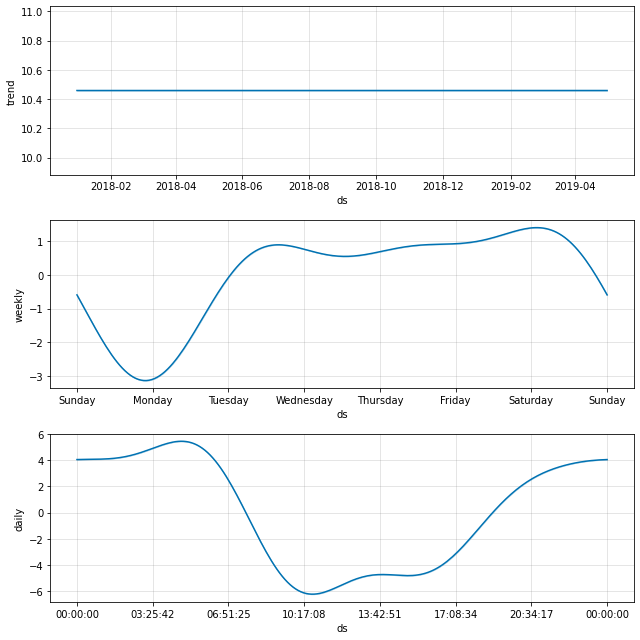

In [139]:
year_model.plot_components(forcast);

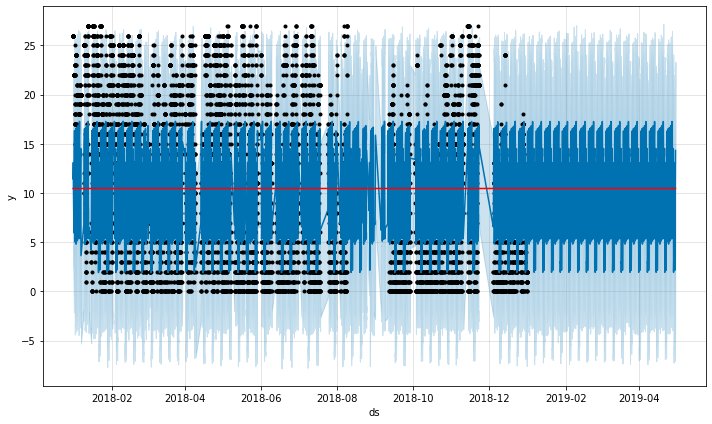

In [140]:
from fbprophet.plot import add_changepoints_to_plot
fig = year_model.plot(forcast)
a = add_changepoints_to_plot(fig.gca(), m, forcast)

In [124]:
station_3172

,station_name,avail_bikes,avail_docks,tot_docks,_lat,_long,in_service,status_key,percent_full,season
date_time,,,,,,,,,,
2018-01-01 00:26:00,W 74 St & Columbus Ave,26.0,1,27,40.778567,-73.97755,1,1,0.962963,winter
2018-01-01 00:59:00,W 74 St & Columbus Ave,26.0,1,27,40.778567,-73.97755,1,1,0.962963,winter
2018-01-01 01:32:00,W 74 St & Columbus Ave,26.0,1,27,40.778567,-73.97755,1,1,0.962963,winter
2018-01-01 02:04:00,W 74 St & Columbus Ave,26.0,1,27,40.778567,-73.97755,1,1,0.962963,winter
2018-01-01 02:38:00,W 74 St & Columbus Ave,26.0,1,27,40.778567,-73.97755,1,1,0.962963,winter
...,...,...,...,...,...,...,...,...,...,...
2018-12-31 20:22:00,W 74 St & Columbus Ave,2.0,25,27,40.778567,-73.97755,1,1,0.074074,winter
2018-12-31 21:13:00,W 74 St & Columbus Ave,2.0,25,27,40.778567,-73.97755,1,1,0.074074,winter
2018-12-31 21:54:00,W 74 St & Columbus Ave,2.0,25,27,40.778567,-73.97755,1,1,0.074074,winter


In [141]:
decomp_prophet = Prophet(growth='flat')
decomp_prophet.add_seasonality(name='daily',period=1,fourier_order=4, prior_scale=10)
decomp_prophet.add_seasonality(name='weekly',period=7,fourier_order=1, prior_scale=10)
decomp_prophet.fit(availbikes)

future = decomp_prophet.make_future_dataframe(periods = 24*119,freq='H')
forcast = decomp_prophet.predict(future)
forcast[['ds','yhat','yhat_lower','yhat_upper']]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.


,ds,yhat,yhat_lower,yhat_upper
0,2018-01-01 00:26:00,12.957388,4.049630,21.994502
1,2018-01-01 00:59:00,12.967281,3.928097,21.855350
2,2018-01-01 01:32:00,13.010577,3.396784,22.010813
3,2018-01-01 02:04:00,13.123322,4.283546,22.541285
4,2018-01-01 02:38:00,13.344415,4.468375,22.247676
...,...,...,...,...
13973,2019-04-29 19:30:00,10.399812,1.417928,19.689496
13974,2019-04-29 20:30:00,11.743865,3.216168,20.919612
13975,2019-04-29 21:30:00,12.600959,3.664468,21.702626
13976,2019-04-29 22:30:00,13.111898,4.687007,21.971602


(736862.0, 736889.0, -5.0, 45.0)

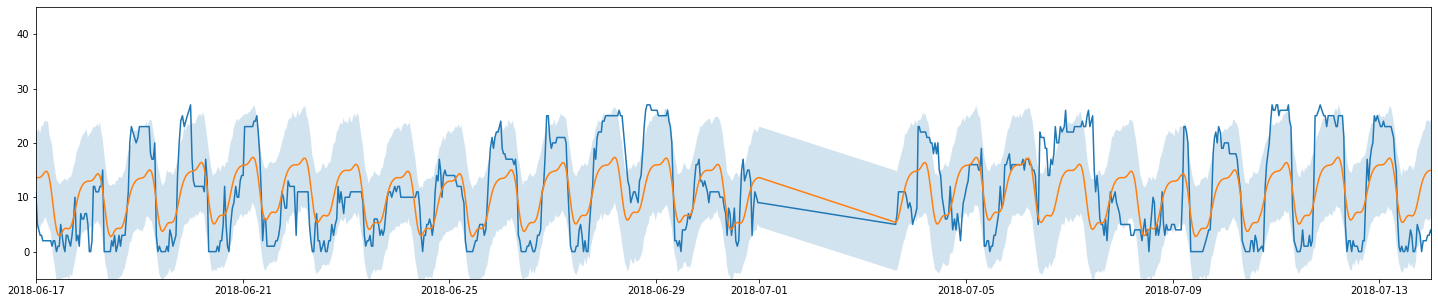

In [142]:
forcast_year_ts = forcast.set_index('ds')
true_year_ts = availbikes.set_index('ds')

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(25)
#ax.plot(test_ts,label='test')
ax.plot(true_year_ts,label='train')
ax.plot(forcast_year_ts.yhat,label='forcast')
ax.fill_between(forcast_year_ts.index,forcast_year_ts.yhat_lower,forcast_year_ts.yhat_upper,alpha=0.2)
plt.axis([np.datetime64('2018-06-17'),np.datetime64('2018-07-14'),-5,45])

In [143]:
train_rmse = mean_squared_error(y_true=true_year_ts.y.interpolate(),
                   y_pred=forcast_year_ts.yhat[:'2018-12-31'],
                   squared=False)

# test_rmse = mean_squared_error(y_true=true_year_ts.interpolate(),
#                                y_pred=forcast_ts.yhat['2018-07-03 15:00:00':],
#                                squared=False)

train_mae = mean_absolute_error(y_true=true_year_ts.y.interpolate(),
                   y_pred=forcast_year_ts.yhat[:'2018-12-31'],)

# test_mae = mean_absolute_error(y_true=test_ts['2018-07-03 15:00:00':].interpolate(),
#                                y_pred=forcast_ts.yhat['2018-07-03 15:00:00':])

print(f'Train RMSE: {train_rmse}')
print(f'Train MAE:  {train_mae}\n')

# print(f'Test RMSE: {test_rmse}')
# print(f'Test MAE:  {test_mae}')

Train RMSE: 7.416465352389299
Train MAE:  6.217350274795366



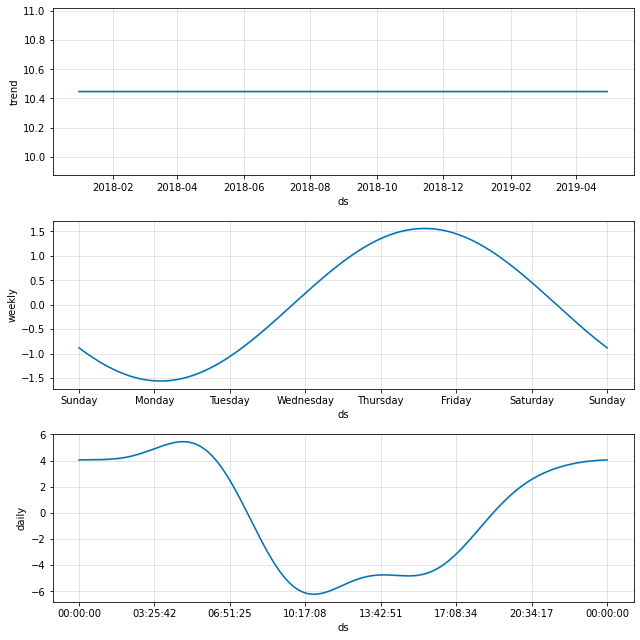

In [144]:
decomp_prophet.plot_components(forcast);

In [145]:
station_3176 = year_2018.loc[3167]['2018-02-01':]